# **PREPROCESS DATA FROM MIT-BIH DATABASE**

In [1]:

import numpy as np
import pandas as pd
import os
import scipy.signal
import pywt
from collections import defaultdict, Counter
from torch.utils.data import Dataset
import torch


# --- 📚 Imports ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal
import pywt
from collections import defaultdict, Counter

import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

from torchinfo import summary
import brevitas.nn as qnn
from brevitas.quant import Int8WeightPerTensorFloat, Int8ActPerTensorFloat

# **MAKE DATASET INTO BEAT WINDOWS**

In [2]:
DATA_DIR = "/home/eveneiha/finn/workspace/ml/data/MITDB/merged_output"

# Valid labels for raw input (before AAMI conversion)
VALID_RAW_LABELS = [
    'N', '·', 'L', 'R', 'e', 'j',
    'A', 'a', 'J', 'S',
    'V', 'E',
    'F',
    '/', 'f', 'Q', '[', ']', '!', 'x', '|'
]

# AAMI Class Mapping
AAMI_CLASSES = {
    'N': ['N', '·', 'L', 'R', 'e', 'j'],
    'S': ['A', 'a', 'J', 'S'],
    'V': ['V', 'E'],
    'F': ['F'],
    'Q': ['/', 'f', 'Q', '[', ']', '!', 'x', '|']
}

# Generate AAMI_MAP from AAMI_CLASSES
AAMI_MAP = {}
for aami_label, raw_list in AAMI_CLASSES.items():
    for raw_label in raw_list:
        AAMI_MAP[raw_label] = aami_label

AAMI_CLASS_NAMES = list(AAMI_CLASSES.keys())  # ['N', 'S', 'V', 'F', 'Q']



# Denoising function remains the same.
def apply_dwt_denoising(ecg_signal, wavelet='db4', level=4):
    coeffs = pywt.wavedec(ecg_signal, wavelet, level=level)
    # Apply soft thresholding to all detail coefficients:
    coeffs[1:] = [pywt.threshold(c, np.std(c) * 0.5, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)[:len(ecg_signal)]

def load_data(csv_file):
    try:
        df = pd.read_csv(csv_file)
    except FileNotFoundError:
        print(f"File not found: {csv_file}")
        return None, None, None

    # Normalize and denoise
    ecg = df['MLII'].astype(np.float32).values
    ecg = (ecg - np.mean(ecg)) / np.std(ecg)
    ecg = apply_dwt_denoising(ecg)

    label_series = df[df['Type'] != '-'][['Sample', 'Type']]
    r_peaks = label_series['Sample'].astype(int).values

    return ecg, label_series, r_peaks

class ECGDataset(Dataset):
    def __init__(self, data_dir, beat_length, beats_per_window):
        super().__init__()
        self.data_dir = data_dir
        self.beat_length = beat_length      # fixed output length (e.g., 1000 samples)
        self.beats_per_window = beats_per_window  # should be odd to center the target beat
        self.labeled_events = []              # Each event is now a tuple: (window_id, filename, ecg_tensor, raw_label, sample_num)
        self.label_counts = defaultdict(int)
        self.event_counter = 0                # to generate unique window IDs

        for filename in os.listdir(data_dir):
            if not filename.endswith('.csv'):
                continue
            ecg_sig, label_series, r_peaks = load_data(os.path.join(data_dir, filename))
            if ecg_sig is None or len(r_peaks) < beats_per_window:
                continue

            for _, row in label_series.iterrows():
                sample_num = int(row['Sample'])
                raw_label = row['Type']
                # Make sure the raw label is valid.
                if raw_label not in VALID_RAW_LABELS:
                    continue

                beat = self.extract_multibeat_window(ecg_sig, r_peaks, sample_num, beats_per_window)
                if beat is not None:
                    # Normalize after centering
                    beat = self.normalize_to_float32(beat)
                    # Generate a unique window id using the event counter.
                    window_id = f"win_{self.event_counter:06d}"
                    self.event_counter += 1
                    # Save as (window_id, filename, tensor, label, sample number)
                    self.labeled_events.append((window_id, filename, torch.tensor(beat, dtype=torch.float32), raw_label, sample_num))
                    self.label_counts[raw_label] += 1

    def extract_multibeat_window(self, signal, r_peaks, center_sample, beats_per_window):
        """
        Extract a window corresponding to a fixed number of beats (preserving the natural RR intervals).
        Then, uniformly resample that segment to a fixed length (self.beat_length),
        compute where the target (center) R-peak lands in the resampled signal, and
        shift the resampled signal (by zero padding on one side) so that the target R-peak
        is exactly centered in the fixed-length output.
        """
        #print(f"r_peak: {r_peaks} Center_sample: {center_sample}")
        # Find the index where r_peaks equals center_sample.
        center_idx_arr = np.where(r_peaks == center_sample)[0]
        if len(center_idx_arr) == 0:
            return None
        center_idx = center_idx_arr[0]
        #print(center_idx)


        half_window = (beats_per_window - 1) // 2

        # Check for enough beats on both sides.
        if center_idx < half_window or (center_idx + half_window + 1) >= len(r_peaks):
            return None

        # Define the window boundaries using R-peak indices.
        start_idx = r_peaks[center_idx - half_window]
        center_R_peak = r_peaks[center_idx]  # actual sample index of the target R-peak.
        end_idx = r_peaks[center_idx + half_window + 1]  # end index (exclusive)

        # Extract the raw segment that spans the fixed-beat window.
        segment = signal[start_idx:end_idx]

        # Uniformly resample the segment to the fixed length.
        resampled = scipy.signal.resample(segment, self.beat_length)

        # Compute the position in the resampled array corresponding to the center R-peak.
        center_idx_resampled = int((center_R_peak - start_idx) / (end_idx - start_idx) * self.beat_length)

        # Compute the shift required to bring the target pulse to the center of the output.
        desired_center = self.beat_length // 2
        shift = desired_center - center_idx_resampled

        # Create an output array initialized with zeros.
        out = np.zeros(self.beat_length, dtype=resampled.dtype)

        # Shift the resampled signal with zero padding.
        if shift >= 0:
            # If shift is positive, pad the beginning.
            effective_length = self.beat_length - shift
            out[shift:shift+effective_length] = resampled[:effective_length]
        else:
            # If shift is negative, pad the end.
            effective_length = self.beat_length + shift  # (since shift is negative)
            out[:effective_length] = resampled[-shift:-shift+effective_length]

        return out

    def normalize_to_float32(self, x):
        min_val = np.min(x)
        max_val = np.max(x)
        if max_val - min_val == 0:
            return np.zeros_like(x, dtype=np.float32)
        normalized = 2 * (x - min_val) / (max_val - min_val) - 1
        return normalized.astype(np.float32)

    # def normalize_to_int8_range(self, x):
    #     abs_max = np.max(np.abs(x))
    #     if abs_max == 0:
    #         return np.zeros_like(x, dtype=np.float32)
    #     scale = 127 / abs_max  # So that max value maps to 127, min to -127
    #     normalized = x * scale
    #     return normalized.astype(np.float32)

    # def normalize_to_int8_using_old_scaler(self, x):
    #   min_val = np.min(x)
    #   max_val = np.max(x)
    #   if max_val - min_val == 0:
    #       return np.zeros_like(x, dtype=np.int8)

    #   # Normalize to [-1, 1]
    #   normalized = 2 * (x - min_val) / (max_val - min_val) - 1

    #   # Scale to int8 range [-127, 127]
    #   quantized = np.round(normalized * 127).clip(-127, 127)

    #   return quantized.astype(np.int8)


    def __len__(self):
        return len(self.labeled_events)

    def __getitem__(self, idx):
        # The stored tuple is: (window_id, filename, ecg_tensor, label, sample_num)
        window_id, _, ecg, label, _ = self.labeled_events[idx]
        # Return shape: [channels=1, beat_length, 1]
        return ecg.view(1, self.beat_length, 1), label, window_id

    def get_event_by_window_id(self, window_id):
        for event in self.labeled_events:
            if event[0] == window_id:
                return event
        return None

    def print_label_distribution(self):
        print("\n📊 Raw Label Distribution:")
        for label, count in sorted(self.label_counts.items(), key=lambda x: -x[1]):
            print(f"  {repr(label)}: {count} samples")

    def remove_labels_from_dataset(self, labels_to_remove):
        initial_count = len(self.labeled_events)
        self.labeled_events = [
            (win_id, f, ecg, label, sample_num)
            #print(self.labeled_events)
            for (win_id, f, ecg, label, sample_num) in self.labeled_events
            if label not in labels_to_remove
        ]
        self.label_counts = Counter(label for _, _, _, label, _ in self.labeled_events)
        removed_count = initial_count - len(self.labeled_events)
        print(f"🧹 Removed {removed_count} samples with labels: {labels_to_remove}")
        self.print_label_distribution()

# Example Usage:
# Make sure DATA_DIR and VALID_RAW_LABELS are defined.
# For instance:
# DATA_DIR = "path/to/ecg/csv_files"
# VALID_RAW_LABELS = ['N', 'S', 'V', 'F', 'Q']

dataset = ECGDataset(DATA_DIR, beat_length=1000, beats_per_window=7)
dataset.print_label_distribution()



📊 Raw Label Distribution:
  'N': 73278 samples
  'L': 8057 samples
  'R': 7238 samples
  'V': 7058 samples
  '/': 3608 samples
  'A': 2529 samples
  'F': 801 samples
  '!': 472 samples
  'f': 260 samples
  'j': 229 samples
  'a': 149 samples
  '|': 132 samples
  'E': 106 samples
  'x': 85 samples
  'J': 83 samples
  'e': 16 samples
  'Q': 15 samples
  '[': 6 samples
  ']': 6 samples
  'S': 2 samples


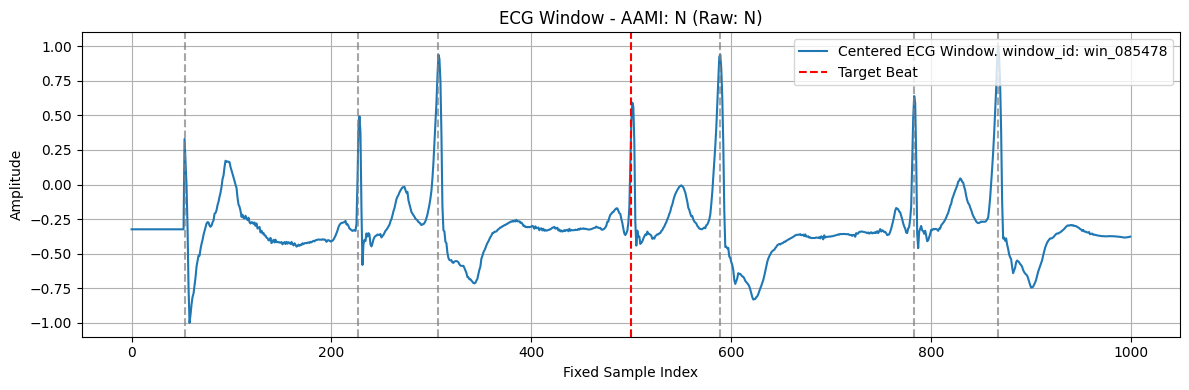

In [3]:
import random
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal

def plot_random_multibeat_window(dataset, label_filter=None, title_label='raw', figsize=(12, 4)):
    """
    Plot a random ECG window with the target (central) beat marked in red,
    and all other R-peak positions in the window marked in gray.

    This version mimics the new extraction logic:
      - The raw segment is extracted based on a fixed number of beats.
      - It is uniformly resampled to a fixed length.
      - Then a shift (with zero padding) is applied so that the target beat lands
        exactly at the center.

    Parameters:
      - dataset: an instance of ECGDataset (with centralized window extraction)
      - label_filter: str or list of str to filter for specific labels (optional)
      - title_label: 'raw' or 'aami', determines which label to show in title
      - figsize: tuple, figure size for plot
    """
    assert title_label in ['raw', 'aami'], "title_label must be 'raw' or 'aami'"

    # Filter the dataset if a label filter is provided.
    if label_filter:
        if isinstance(label_filter, str):
            label_filter = [label_filter]
        filtered_events = [e for e in dataset.labeled_events if e[2] in label_filter]
        if not filtered_events:
            print(f"❌ No samples found with label(s): {label_filter}")
            return
    else:
        filtered_events = dataset.labeled_events

    # Select a random event from the filtered list.
    window_id, filename, ecg_tensor, raw_label, sample_num = random.choice(filtered_events)
    ecg_np = ecg_tensor.squeeze().numpy()  # This is the fixed-length, centered output

    # Load the original signal and R-peaks from the CSV.
    full_path = os.path.join(dataset.data_dir, filename)
    df = pd.read_csv(full_path)
    ecg_sig = (df['MLII'].astype(np.float32) - df['MLII'].mean()) / df['MLII'].std()
    r_peaks = df[df['Type'] != '-']['Sample'].astype(int).values

    # Locate the target (central) beat in the r_peaks array.
    peak_idx_arr = np.where(r_peaks == sample_num)[0]
    if len(peak_idx_arr) == 0:
        print("⚠️ Could not find the labeled beat in R-peaks.")
        return
    peak_idx = peak_idx_arr[0]

    beats_per_window = dataset.beats_per_window
    half_window = (beats_per_window - 1) // 2

    # Check for enough context.
    if peak_idx < half_window or (peak_idx + half_window + 1) > len(r_peaks):
        print("⚠️ Not enough context beats to plot this sample.")
        return

    # Define the window boundaries using R-peak indices.
    start_idx = r_peaks[peak_idx - half_window]
    end_idx   = r_peaks[peak_idx + half_window + 1]  # end_idx is exclusive
    # (The target beat's actual sample is r_peaks[peak_idx])

    # Compute the unshifted positions if we uniformly resampled the extracted segment.
    fixed_len = dataset.beat_length  # e.g., 1000 samples.

    # The unshifted target (center) position based on linear interpolation:
    unshifted_center = int((r_peaks[peak_idx] - start_idx) / (end_idx - start_idx) * fixed_len)
    # The required shift so that the target lands at the center.
    shift = fixed_len // 2 - unshifted_center

    # Compute the adjusted positions for all beats in the window.
    mask = (r_peaks >= start_idx) & (r_peaks < end_idx)
    window_r_peaks = r_peaks[mask]
    beat_positions = {}
    for r in window_r_peaks:
        # Compute the position in the uniformly resampled window.
        pos_unshifted = int((r - start_idx) / (end_idx - start_idx) * fixed_len)
        pos_shifted = pos_unshifted + shift
        # Ensure the position lies within [0, fixed_len).
        pos_shifted = max(0, min(fixed_len - 1, pos_shifted))
        beat_positions[r] = pos_shifted

    # For our new extraction, the target beat is forced to fixed_len//2:
    labeled_position = fixed_len // 2

    # Choose title based on label mapping
    if title_label == 'aami':
        aami_label = AAMI_MAP.get(raw_label, 'Unknown')  # if AAMI_MAP exists
        title = f"ECG Window - AAMI: {aami_label} (Raw: {raw_label})"
    else:
        title = f"ECG Window - Raw Label: {raw_label}"

    # Plot the resampled and centered ECG window.
    plt.figure(figsize=figsize)
    plt.plot(ecg_np, label=f"Centered ECG Window. window_id: {window_id}")

    # Mark all beats.
    for r, pos in beat_positions.items():
        if r == sample_num:
            # The target beat.
            plt.axvline(x=pos, color='r', linestyle='--', label="Target Beat")
        else:
            plt.axvline(x=pos, color='gray', linestyle='--', alpha=0.7)

    plt.title(title)
    plt.xlabel("Fixed Sample Index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Then call your plotting function:
plot_random_multibeat_window(dataset, title_label='aami')


In [4]:
dataset.remove_labels_from_dataset(['[',']', 'S'])
from sklearn.model_selection import train_test_split


def convert_to_aami(dataset):
    new_labeled = []
    aami_counts = defaultdict(int)

    for w, f, ecg, raw_label, sample_num in dataset.labeled_events:
        if raw_label in AAMI_MAP:
            aami_label = AAMI_MAP[raw_label]
            new_labeled.append((w, f, ecg, aami_label, sample_num))
            aami_counts[aami_label] += 1

    dataset.labeled_events = new_labeled
    dataset.label_counts = aami_counts
    print("\n🔁 Converted to AAMI labels:")
    for label, count in sorted(aami_counts.items(), key=lambda x: -x[1]):
        print(f"  {label}: {count} samples")


convert_to_aami(dataset)

🧹 Removed 14 samples with labels: ['[', ']', 'S']

📊 Raw Label Distribution:
  'N': 73278 samples
  'L': 8057 samples
  'R': 7238 samples
  'V': 7058 samples
  '/': 3608 samples
  'A': 2529 samples
  'F': 801 samples
  '!': 472 samples
  'f': 260 samples
  'j': 229 samples
  'a': 149 samples
  '|': 132 samples
  'E': 106 samples
  'x': 85 samples
  'J': 83 samples
  'e': 16 samples
  'Q': 15 samples

🔁 Converted to AAMI labels:
  N: 88818 samples
  V: 7164 samples
  Q: 4572 samples
  S: 2761 samples
  F: 801 samples


In [5]:
from sklearn.model_selection import train_test_split
from collections import defaultdict, Counter
import torch
import random
import os
import numpy as np
import pandas as pd
import scipy.signal
from torch.utils.data import Subset, DataLoader


# --- Stratified Split (using converted AAMI labels) ---
def stratified_split(dataset, train_size=0.7, val_size=0.15, test_size=0.15):
    assert abs(train_size + val_size + test_size - 1.0) < 1e-6, "Splits must sum to 1"

    # Note: Each element in dataset.labeled_events is expected to be a 5-tuple:
    # (window_id, filename, ecg_tensor, label, sample_num)
    labels = [label for _, _, _, label, _ in dataset.labeled_events]
    indices = list(range(len(labels)))

    # Split train and temp
    train_idx, temp_idx = train_test_split(indices, stratify=labels, test_size=(val_size + test_size), random_state=42)
    temp_labels = [labels[i] for i in temp_idx]

    # Split temp into val and test
    val_relative_size = val_size / (val_size + test_size)
    val_idx, test_idx = train_test_split(temp_idx, stratify=temp_labels, test_size=1 - val_relative_size, random_state=42)

    return train_idx, val_idx, test_idx

def subset_to_tensors(subset):
    inputs = []
    labels = []
    window_ids = []
    for inp, lab, win_id in subset:
        inputs.append(inp)
        # Convert the label (string) to numeric using the AAMI_CLASS_NAMES mapping:
        labels.append(AAMI_CLASS_NAMES.index(lab))
        window_ids.append(win_id)
    return torch.stack(inputs), torch.tensor(labels), window_ids

train_idx, val_idx, test_idx = stratified_split(dataset)

train_set = Subset(dataset, train_idx)
val_set = Subset(dataset, val_idx)
test_set = Subset(dataset, test_idx)

train_inputs, train_labels, train_ids = subset_to_tensors(train_set)
val_inputs, val_labels, val_ids = subset_to_tensors(val_set)
test_inputs, test_labels, test_ids = subset_to_tensors(test_set)

## **Save to .pt Files**

In [6]:
SAVE_DIR = "/home/eveneiha/finn/workspace/ml/data/preprocessed"

# Make sure the save directory exists
os.makedirs(SAVE_DIR, exist_ok=True)

train_data = {
    "inputs": train_inputs,
    "labels": train_labels,
    "window_ids": train_ids
}

val_data = {
    "inputs": val_inputs,
    "labels": val_labels,
    "window_ids": val_ids
}

test_data = {
    "inputs": test_inputs,
    "labels": test_labels,
    "window_ids": test_ids
}

# Save the datasets to the correct paths
torch.save(train_data, os.path.join(SAVE_DIR, "train.pt"))
print(f"Saved train dataset to {os.path.join(SAVE_DIR, 'train.pt')}")

torch.save(val_data, os.path.join(SAVE_DIR, "val.pt"))
print(f"Saved val dataset to {os.path.join(SAVE_DIR, 'val.pt')}")

torch.save(test_data, os.path.join(SAVE_DIR, "test.pt"))
print(f"Saved test dataset to {os.path.join(SAVE_DIR, 'test.pt')}")

Saved train dataset to /home/eveneiha/finn/workspace/ml/data/preprocessed/train.pt
Saved val dataset to /home/eveneiha/finn/workspace/ml/data/preprocessed/val.pt
Saved test dataset to /home/eveneiha/finn/workspace/ml/data/preprocessed/test.pt
